# Individual Project:  Nifty 100 Index Closing Price Regression

- Goal: Develop an ML regression model to attempt to predict the closing price for the Nifty 100 Index

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars

import prep
from acquire import get_nifty_100
from wrangle import wrangle_nifty
from evaluate import get_rmse



import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)

### Acquire data

In [2]:
# Run acquire function
nifty_df = get_nifty_100()

# Check data
nifty_df.info()
nifty_df.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276568 entries, 0 to 276567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    276568 non-null  object 
 1   Time    276568 non-null  object 
 2   Open    276568 non-null  float64
 3   High    276568 non-null  float64
 4   Low     276568 non-null  float64
 5   Close   276568 non-null  float64
dtypes: float64(4), object(2)
memory usage: 12.7+ MB


,Date,Time,Open,High,Low,Close
0,02/01/2017,09:07:59,8409.6,8409.6,8409.6,8409.6
1,02/01/2017,09:08:59,8409.6,8409.6,8409.6,8409.6
2,02/01/2017,09:09:59,8409.6,8409.6,8409.6,8409.6
3,02/01/2017,09:10:59,8409.6,8409.6,8409.6,8409.6
4,02/01/2017,09:11:59,8409.6,8409.6,8409.6,8409.6


### Takeaways:

Acquire function read in a dataset containing 276568 records. Data appears to be clean, consisting of two time elements, and four continuous variables that are variations on price.

### Wrangle data

In [3]:
# Run wrangle function
nifty_df = wrangle_nifty(nifty_df)

# Check data
nifty_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276568 entries, 2017-02-01 09:07:59 to 2019-12-31 16:00:59
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    276568 non-null  float64
 1   high    276568 non-null  float64
 2   low     276568 non-null  float64
 3   close   276568 non-null  float64
dtypes: float64(4)
memory usage: 10.6 MB


### Takeaways:

After very minor wrangling that combined Date and Time columns into a new column and set it as the index, we are left with price features only.

### Explore data

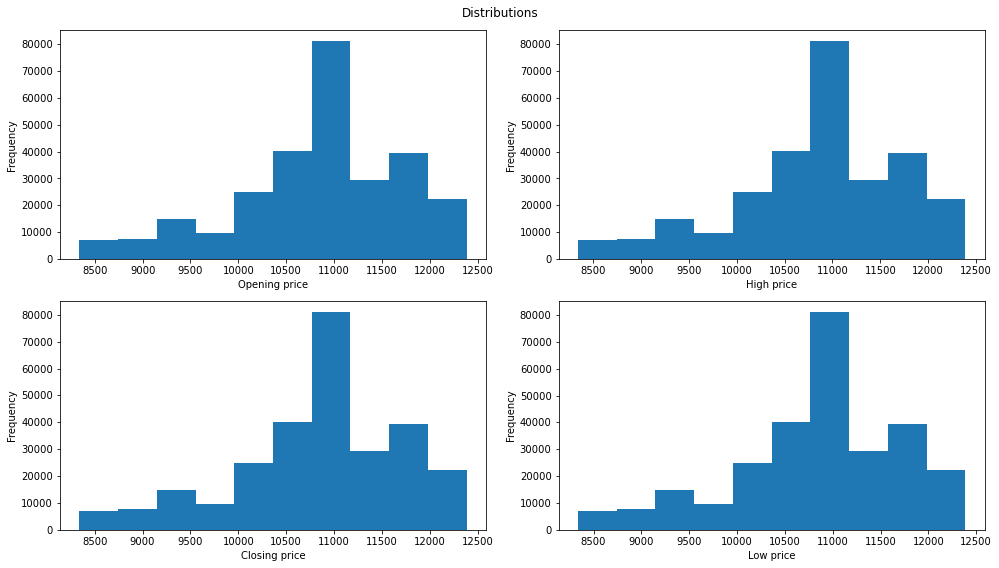

In [4]:
# Plot distributions
plt.figure(figsize= (14,8))
plt.suptitle('Distributions')

plt.subplot(221)
nifty_df.open.plot.hist()
plt.xlabel('Opening price')

plt.subplot(222)
nifty_df.high.plot.hist()
plt.xlabel('High price')

plt.subplot(223)
nifty_df.close.plot.hist()
plt.xlabel('Closing price')

plt.subplot(224)
nifty_df.low.plot.hist()
plt.xlabel('Low price')

plt.tight_layout()

### Takeaways:

Distributions mostly normal. 

### View variables resampled by year, month, week, day, hour, and minute

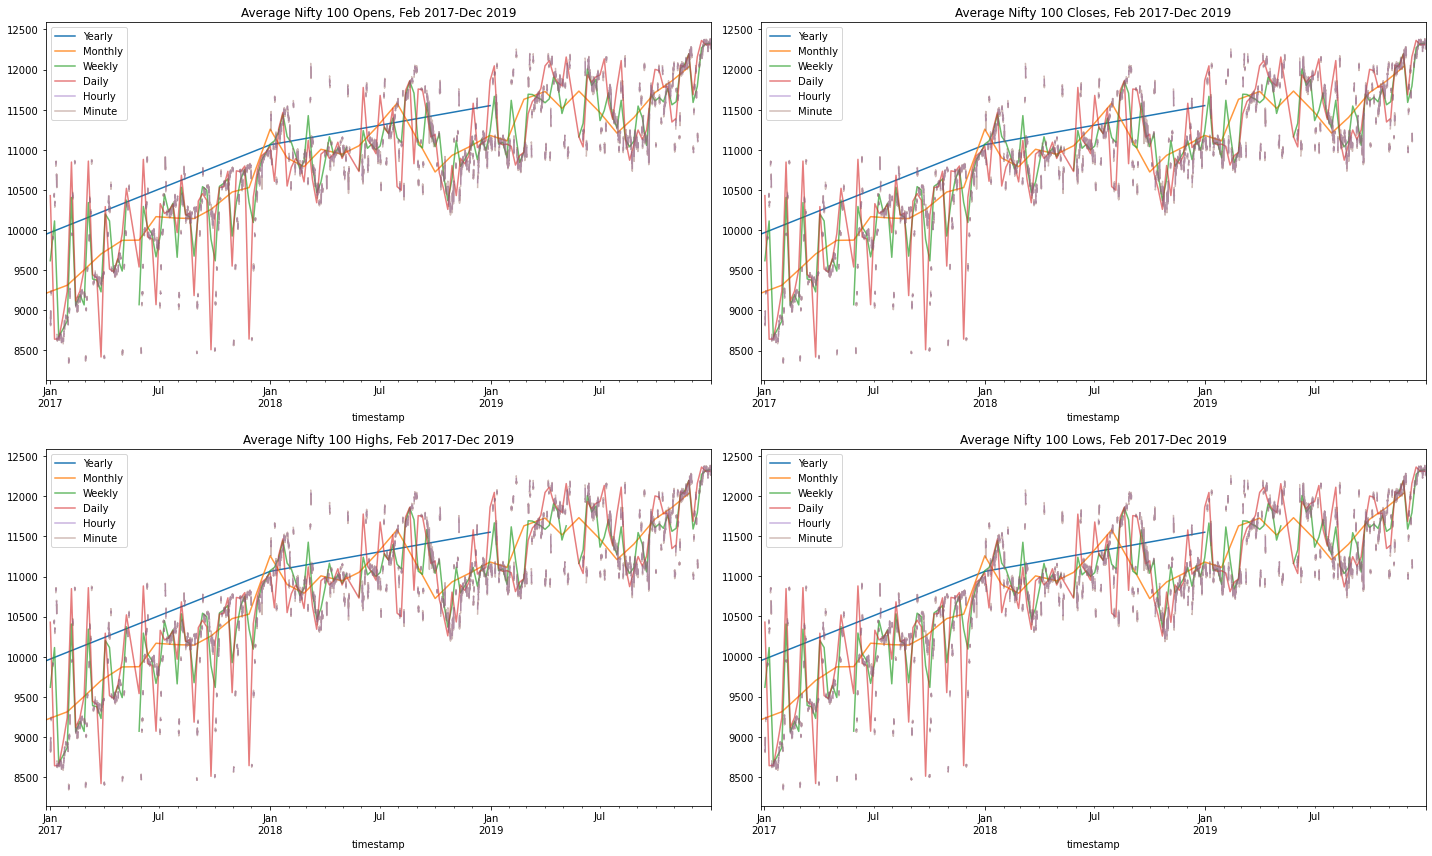

In [5]:
#plot variables resampled by year, month, week, day, hour and minute
plt.figure(figsize=(20,12))

plt.subplot(221)
nifty_df.resample('Y').open.mean().plot(label='Yearly')
nifty_df.resample('M').open.mean().plot(alpha=.8, label='Monthly')
nifty_df.resample('W').open.mean().plot(alpha=.7, label='Weekly')
nifty_df.resample('D').open.mean().plot(alpha=.6, label='Daily')
nifty_df.resample('H').open.mean().plot(alpha=.5, label='Hourly')
nifty_df.resample('T').open.mean().plot(alpha=.4, label='Minute')

plt.title('Average Nifty 100 Opens, Feb 2017-Dec 2019')
plt.legend()

plt.subplot(222)
nifty_df.resample('Y').close.mean().plot(label='Yearly')
nifty_df.resample('M').close.mean().plot(alpha=.8, label='Monthly')
nifty_df.resample('W').close.mean().plot(alpha=.7, label='Weekly')
nifty_df.resample('D').close.mean().plot(alpha=.6, label='Daily')
nifty_df.resample('H').close.mean().plot(alpha=.5, label='Hourly')
nifty_df.resample('T').close.mean().plot(alpha=.4, label='Minute')

plt.title('Average Nifty 100 Closes, Feb 2017-Dec 2019')
plt.legend()

plt.subplot(223)
nifty_df.resample('Y').high.mean().plot(label= 'Yearly')
nifty_df.resample('M').high.mean().plot(alpha=.8, label='Monthly')
nifty_df.resample('W').high.mean().plot(alpha=.7, label='Weekly')
nifty_df.resample('D').high.mean().plot(alpha=.6, label='Daily')
nifty_df.resample('H').high.mean().plot(alpha=.5, label='Hourly')
nifty_df.resample('T').high.mean().plot(alpha=.4, label='Minute')

plt.title('Average Nifty 100 Highs, Feb 2017-Dec 2019')
plt.legend()

plt.subplot(224)
nifty_df.resample('Y').low.mean().plot(label='Yearly')
nifty_df.resample('M').low.mean().plot(alpha=.8, label='Monthly')
nifty_df.resample('W').low.mean().plot(alpha=.7, label='Weekly')
nifty_df.resample('D').low.mean().plot(alpha=.6, label='Daily')
nifty_df.resample('H').low.mean().plot(alpha=.5, label='Hourly')
nifty_df.resample('T').low.mean().plot(alpha=.4, label='Minute')

plt.title('Average Nifty 100 Lows, Feb 2017-Dec 2019')
plt.legend()

plt.tight_layout()

### Takeaways:

The similarity between the graphs of all these variables indicates probable high correlation strength between them all.

### Prepare data for modeling

In [6]:
# Engineer a mid-range feature
nifty_df['mid_range']= (nifty_df.high + nifty_df.low) / 2

# Check data's summary stats
nifty_df.describe()


,open,high,low,close,mid_range
count,276568.000000,276568.000000,276568.000000,276568.000000,276568.000000
mean,10854.305947,10855.938662,10852.626565,10854.252050,10854.282614
std,850.887604,851.089535,850.705353,850.901303,850.896240
min,8339.700000,8340.300000,8337.200000,8339.900000,8338.750000
25%,10431.200000,10432.050000,10429.400000,10431.200000,10431.100000
50%,10956.600000,10958.550000,10954.750000,10956.600000,10956.725000
75%,11461.150000,11463.700000,11459.012500,11461.050000,11461.100000
max,12385.950000,12387.300000,12384.450000,12385.500000,12385.875000


In [7]:
nifty_df.head()

,open,high,low,close,mid_range
timestamp,,,,,
2017-02-01 09:07:59,8409.6,8409.6,8409.6,8409.6,8409.6
2017-02-01 09:08:59,8409.6,8409.6,8409.6,8409.6,8409.6
2017-02-01 09:09:59,8409.6,8409.6,8409.6,8409.6,8409.6
2017-02-01 09:10:59,8409.6,8409.6,8409.6,8409.6,8409.6
2017-02-01 09:11:59,8409.6,8409.6,8409.6,8409.6,8409.6


Visualize new mid-range feature in composite with 'high' price feature, using resampling methods

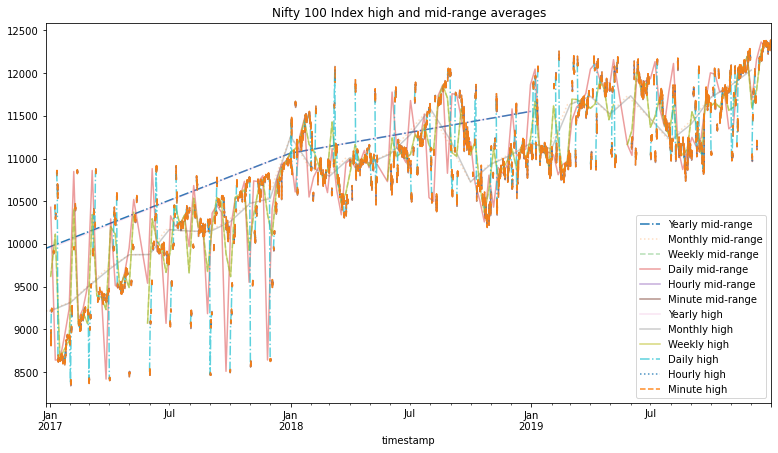

In [8]:
plt.figure(figsize=(13,7))
nifty_df.resample('Y').mid_range.mean().plot(label='Yearly mid-range', ls= '-.')
nifty_df.resample('M').mid_range.mean().plot(alpha=.25, label='Monthly mid-range', ls=':')
nifty_df.resample('W').mid_range.mean().plot(alpha=.35, label='Weekly mid-range', ls='--')
nifty_df.resample('D').mid_range.mean().plot(alpha=.45, label='Daily mid-range')
nifty_df.resample('H').mid_range.mean().plot(alpha=.55, label='Hourly mid-range')
nifty_df.resample('T').mid_range.mean().plot(alpha=.65, label='Minute mid-range')

nifty_df.resample('Y').high.mean().plot(alpha=.2, label='Yearly high')
nifty_df.resample('M').high.mean().plot(alpha=.4, label='Monthly high')
nifty_df.resample('W').high.mean().plot(alpha=.6, label='Weekly high')
nifty_df.resample('D').high.mean().plot(alpha=.7, label='Daily high', ls='-.')
nifty_df.resample('H').high.mean().plot(alpha=.8, label='Hourly high', ls=':')
nifty_df.resample('T').high.mean().plot(alpha=.9, label='Minute high', ls='--')
plt.title('Nifty 100 Index high and mid-range averages')
plt.legend()

### Takeaways:

This composite visualization of the new mid-range price feature with the high price feature further indicates the data's linearity.

### Split data into train, validate, and test splits by proportional method.

In [9]:
# Prepare to make splits
train_size = round(len(nifty_df) * .5)
validate_size = round(len(nifty_df) * .3)
test_size= len(nifty_df) - train_size - validate_size
val_end_idx = train_size + validate_size

# Make splits
train = nifty_df[:train_size]
validate = nifty_df[train_size:val_end_idx]
test = nifty_df[val_end_idx:]

train.size + validate.size + test.size == nifty_df.size

True

### Are there linear relationships with any of the combinations of the variables open, close, high, low, or mid_range?

$H_0:$ There is no relationship between x and y (where x and y are variables in the train split).

$H_a:$ A relationship does exist between x and y.

In [10]:
for col in train.columns:
    alpha= .05

    r_coeff, pval = stats.pearsonr(train[col], train.close)

    if pval < alpha:
        print(f'We can reject the null hypothesis with a confidence level of {1 - pval:.3%}\nCorrelation strength:{r_coeff:.3f}')
    else:
        print(f'We fail to reject the null hypothesis. Our confidence level was {1 - pval:.3%}, which is less than our standard of {1 - alpha:.3%}\nCorrelation strength: {r_coeff:.3f}')

We can reject the null hypothesis with a confidence level of 100.000%
Correlation strength:1.000
We can reject the null hypothesis with a confidence level of 100.000%
Correlation strength:1.000
We can reject the null hypothesis with a confidence level of 100.000%
Correlation strength:1.000
We can reject the null hypothesis with a confidence level of 100.000%
Correlation strength:1.000
We can reject the null hypothesis with a confidence level of 100.000%
Correlation strength:1.000


### Takeaways:

Statistical testing (Pearson's R) confirms linearity of the data.

### Isolate closing price ('close') as target

- Is closing price predictable?

In [11]:
# Isolate target variable
X_train, y_train, X_validate, y_validate, X_test, y_test = prep.isolate_lm_target(train,validate,test,'close')

# Sanity check data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138284 entries, 2017-02-01 09:07:59 to 2018-07-13 11:15:59
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   open       138284 non-null  float64
 1   high       138284 non-null  float64
 2   low        138284 non-null  float64
 3   mid_range  138284 non-null  float64
dtypes: float64(4)
memory usage: 5.3 MB


Scale X and y splits.

In [12]:
# Use prep function to scale splits
X_train_scaled, X_validate_scaled, X_test_scaled = prep.minmax_scale_data(X_train, X_validate, X_test, X_train.columns)

# Check data
X_train_scaled.head()

,open,high,low,mid_range
timestamp,,,,
2017-02-01 09:07:59,0.021784,0.021572,0.022565,0.022085
2017-02-01 09:08:59,0.021784,0.021572,0.022565,0.022085
2017-02-01 09:09:59,0.021784,0.021572,0.022565,0.022085
2017-02-01 09:10:59,0.021784,0.021572,0.022565,0.022085
2017-02-01 09:11:59,0.021784,0.021572,0.022565,0.022085


### Modeling

In [13]:
# OLS model 1
lm1 = LinearRegression(normalize=True)
lm1.fit(X_train_scaled, y_train.close)

y_train['yhat_lm1'] = lm1.predict(X_train_scaled)

# LASSO + LARS model
lm2 = LassoLars(alpha=1.0)
lm2.fit(X_train_scaled, y_train.close)

y_train['yhat_lm2'] = lm2.predict(X_train_scaled)

# GLM model
lm3 = TweedieRegressor(power=1, alpha=0)
lm3.fit(X_train_scaled, y_train.close)

y_train['yhat_lm3'] = lm3.predict(X_train_scaled)

# OLS model 2 (with RFE selected features)
rfe_feature, rfe_ranked = prep.rfe(X_train_scaled, y_train.close, 3)
print(f'RFE ranked features:\n{rfe_ranked}')

lm4 = LinearRegression()
lm4.fit(X_train_scaled[rfe_feature], y_train.close)

y_train['yhat_lm4'] = lm4.predict(X_train_scaled[rfe_feature])

#OLS model 3 (with Select K Best features)
f_feature = prep.select_kbest(X_train_scaled, y_train.close, 2)
print(f'Select K Best features:\n{f_feature}')

lm5 = LinearRegression()
lm5.fit(X_train_scaled[f_feature], y_train.close)

y_train['yhat_lm5'] = lm5.predict(X_train_scaled[f_feature])

y_train

RFE ranked features:
         Var  Rank
0       open     2
1       high     1
2        low     1
3  mid_range     1
Select K Best features:
['low', 'mid_range']


,close,yhat_lm1,yhat_lm2,yhat_lm3,yhat_lm4,yhat_lm5
timestamp,,,,,,
2017-02-01 09:07:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700
2017-02-01 09:08:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700
2017-02-01 09:09:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700
2017-02-01 09:10:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700
2017-02-01 09:11:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700
...,...,...,...,...,...,...
2018-07-13 11:11:59,11257.30,11257.268186,10771.498519,11306.227567,11256.966917,11256.965697
2018-07-13 11:12:59,11256.20,11255.809202,10771.260362,11303.723868,11256.410276,11256.414168
2018-07-13 11:13:59,11255.80,11255.551390,10770.896859,11304.115375,11255.748167,11255.748176


Calculate baseline 


In [14]:
y_train['base_line'] = y_train.close.mean()

Calculate raw absolute differences between models and target

In [15]:
y_train['lm1_delta'] = abs(y_train.close - y_train.yhat_lm1)
y_train['lm2_delta'] = abs(y_train.close - y_train.yhat_lm2)
y_train['lm3_delta'] = abs(y_train.close - y_train.yhat_lm3)
y_train['lm4_delta'] = abs(y_train.close - y_train.yhat_lm4)
y_train['lm5_delta'] = abs(y_train.close - y_train.yhat_lm5)
y_train['bl_delta'] = abs(y_train.base_line - y_train.close)

y_train

,close,yhat_lm1,yhat_lm2,yhat_lm3,yhat_lm4,yhat_lm5,base_line,lm1_delta,lm2_delta,lm3_delta,lm4_delta,lm5_delta,bl_delta
timestamp,,,,,,,,,,,,,
2017-02-01 09:07:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700,10283.43762,0.007725,934.311704,92.965207,0.041569,0.037700,1873.83762
2017-02-01 09:08:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700,10283.43762,0.007725,934.311704,92.965207,0.041569,0.037700,1873.83762
2017-02-01 09:09:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700,10283.43762,0.007725,934.311704,92.965207,0.041569,0.037700,1873.83762
2017-02-01 09:10:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700,10283.43762,0.007725,934.311704,92.965207,0.041569,0.037700,1873.83762
2017-02-01 09:11:59,8409.60,8409.607725,9343.911704,8502.565207,8409.641569,8409.637700,10283.43762,0.007725,934.311704,92.965207,0.041569,0.037700,1873.83762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-13 11:11:59,11257.30,11257.268186,10771.498519,11306.227567,11256.966917,11256.965697,10283.43762,0.031814,485.801481,48.927567,0.333083,0.334303,973.86238
2018-07-13 11:12:59,11256.20,11255.809202,10771.260362,11303.723868,11256.410276,11256.414168,10283.43762,0.390798,484.939638,47.523868,0.210276,0.214168,972.76238
2018-07-13 11:13:59,11255.80,11255.551390,10770.896859,11304.115375,11255.748167,11255.748176,10283.43762,0.248610,484.903141,48.315375,0.051833,0.051824,972.36238


Calculate Root Mean Squared Errors

In [16]:
rmse_bl = get_rmse(y_train.close, y_train.base_line)
rmse_lm1 = get_rmse(y_train.close, y_train.yhat_lm1)
rmse_lm2 = get_rmse(y_train.close, y_train.yhat_lm2)
rmse_lm3 = get_rmse(y_train.close, y_train.yhat_lm3)
rmse_lm4 = get_rmse(y_train.close, y_train.yhat_lm4)
rmse_lm5 = get_rmse(y_train.close, y_train.yhat_lm5)

error_data = {'Baseline_RMSE': rmse_bl, 'Model_1_RMSE': rmse_lm1, 'Model_2_RMSE': rmse_lm2,'Model_3_RMSE': rmse_lm3,'Model_4_RMSE': rmse_lm4,'Model_5_RMSE': rmse_lm5}

print(f'Model RMSEs:\n{pd.Series(error_data)}')

Model RMSEs:
Baseline_RMSE    745.788586
Model_1_RMSE       0.973728
Model_2_RMSE     371.868103
Model_3_RMSE      28.974684
Model_4_RMSE       1.369647
Model_5_RMSE       1.369649
dtype: float64


### Model 1, an OLS model using all features, performs the best, with RFE and Select K Best feature-selected models close behind.

Visualize raw absolute differences between models, baseline and target. Resample at year, month, week, day, hour, and minute.

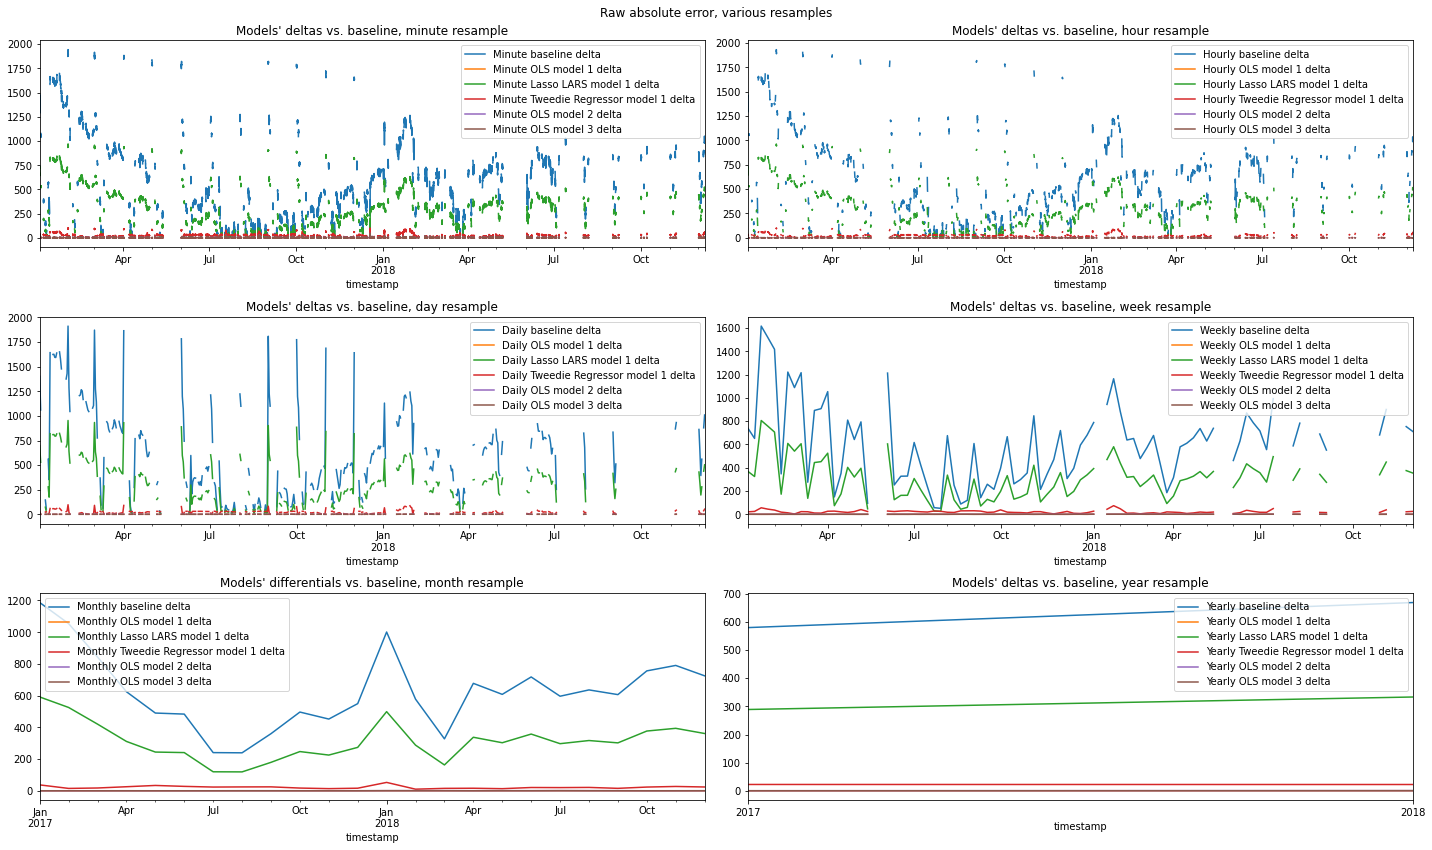

In [17]:
plt.figure(figsize=(20,12))
plt.suptitle('Raw absolute error, various resamples')

plt.subplot(321)
y_train.resample('T').bl_delta.mean().plot(label='Minute baseline delta')
y_train.resample('T').lm1_delta.mean().plot(label='Minute OLS model 1 delta')
y_train.resample('T').lm2_delta.mean().plot(label='Minute Lasso LARS model 1 delta')
y_train.resample('T').lm3_delta.mean().plot(label='Minute Tweedie Regressor model 1 delta')
y_train.resample('T').lm4_delta.mean().plot(label='Minute OLS model 2 delta')
y_train.resample('T').lm5_delta.mean().plot(label='Minute OLS model 3 delta')
plt.title('Models\' deltas vs. baseline, minute resample')
plt.legend()

plt.subplot(322)
y_train.resample('H').bl_delta.mean().plot(label='Hourly baseline delta')
y_train.resample('H').lm1_delta.mean().plot(label='Hourly OLS model 1 delta')
y_train.resample('H').lm2_delta.mean().plot(label='Hourly Lasso LARS model 1 delta')
y_train.resample('H').lm3_delta.mean().plot(label='Hourly Tweedie Regressor model 1 delta')
y_train.resample('H').lm4_delta.mean().plot(label='Hourly OLS model 2 delta')
y_train.resample('H').lm5_delta.mean().plot(label='Hourly OLS model 3 delta')
plt.title('Models\' deltas vs. baseline, hour resample')
plt.legend()

plt.subplot(323)
y_train.resample('D').bl_delta.mean().plot(label='Daily baseline delta')
y_train.resample('D').lm1_delta.mean().plot(label='Daily OLS model 1 delta')
y_train.resample('D').lm2_delta.mean().plot(label='Daily Lasso LARS model 1 delta')
y_train.resample('D').lm3_delta.mean().plot(label='Daily Tweedie Regressor model 1 delta')
y_train.resample('D').lm4_delta.mean().plot(label='Daily OLS model 2 delta')
y_train.resample('D').lm5_delta.mean().plot(label='Daily OLS model 3 delta')
plt.title('Models\' deltas vs. baseline, day resample')
plt.legend()

plt.subplot(324)
y_train.resample('W').bl_delta.mean().plot(label='Weekly baseline delta')
y_train.resample('W').lm1_delta.mean().plot(label='Weekly OLS model 1 delta')
y_train.resample('W').lm2_delta.mean().plot(label='Weekly Lasso LARS model 1 delta')
y_train.resample('W').lm3_delta.mean().plot(label='Weekly Tweedie Regressor model 1 delta')
y_train.resample('W').lm4_delta.mean().plot(label='Weekly OLS model 2 delta')
y_train.resample('W').lm5_delta.mean().plot(label='Weekly OLS model 3 delta')
plt.title('Models\' deltas vs. baseline, week resample')
plt.legend()

plt.subplot(325)
y_train.resample('M').bl_delta.mean().plot(label='Monthly baseline delta')
y_train.resample('M').lm1_delta.mean().plot(label='Monthly OLS model 1 delta')
y_train.resample('M').lm2_delta.mean().plot(label='Monthly Lasso LARS model 1 delta')
y_train.resample('M').lm3_delta.mean().plot(label='Monthly Tweedie Regressor model 1 delta')
y_train.resample('M').lm4_delta.mean().plot(label='Monthly OLS model 2 delta')
y_train.resample('M').lm5_delta.mean().plot(label='Monthly OLS model 3 delta')
plt.title('Models\' differentials vs. baseline, month resample')
plt.legend()

plt.subplot(326)
y_train.resample('Y').bl_delta.mean().plot(label='Yearly baseline delta')
y_train.resample('Y').lm1_delta.mean().plot(label='Yearly OLS model 1 delta')
y_train.resample('Y').lm2_delta.mean().plot(label='Yearly Lasso LARS model 1 delta')
y_train.resample('Y').lm3_delta.mean().plot(label='Yearly Tweedie Regressor model 1 delta')
y_train.resample('Y').lm4_delta.mean().plot(label='Yearly OLS model 2 delta')
y_train.resample('Y').lm5_delta.mean().plot(label='Yearly OLS model 3 delta')
plt.title('Models\' deltas vs. baseline, year resample')
plt.legend()

plt.tight_layout()

### Validate top performing models (OLS 1, 2, 3)

In [18]:
y_validate['yhat_lm1'] = lm1.predict(X_validate_scaled)
y_validate['yhat_lm4'] = lm4.predict(X_validate_scaled[rfe_feature])
y_validate['yhat_lm5'] = lm5.predict(X_validate_scaled[f_feature])

rmse_val_lm1 = get_rmse(y_validate.close, y_validate.yhat_lm1)
rmse_val_lm4 = get_rmse(y_validate.close, y_validate.yhat_lm4)
rmse_val_lm5 = get_rmse(y_validate.close, y_validate.yhat_lm5)

print(f'Model 1 RMSE on validate:{rmse_val_lm1}\nModel 4 RMSE on validate:{rmse_val_lm4}\nModel 5 RMSE:{rmse_val_lm5}')

Model 1 RMSE on validate:1.2523220233334922
Model 4 RMSE on validate:1.8766169486282591
Model 5 RMSE:1.8766030933167863


### Slight dropoff, but no indication of overfitting yet. Model 1 moves on to test.

In [19]:
y_test['yhat_lm1'] = lm1.predict(X_test_scaled)

rmse_test_lm1 = get_rmse(y_test.close, y_test.yhat_lm1)

print(f'Model 1 performance on test: {rmse_test_lm1}')

Model 1 performance on test: 1.3705205517009331


In [20]:
y_test['base_line'] = y_test.close.mean()

get_rmse(y_test.close, y_test.base_line)

433.4893876447503

Visualize model vs. target on test

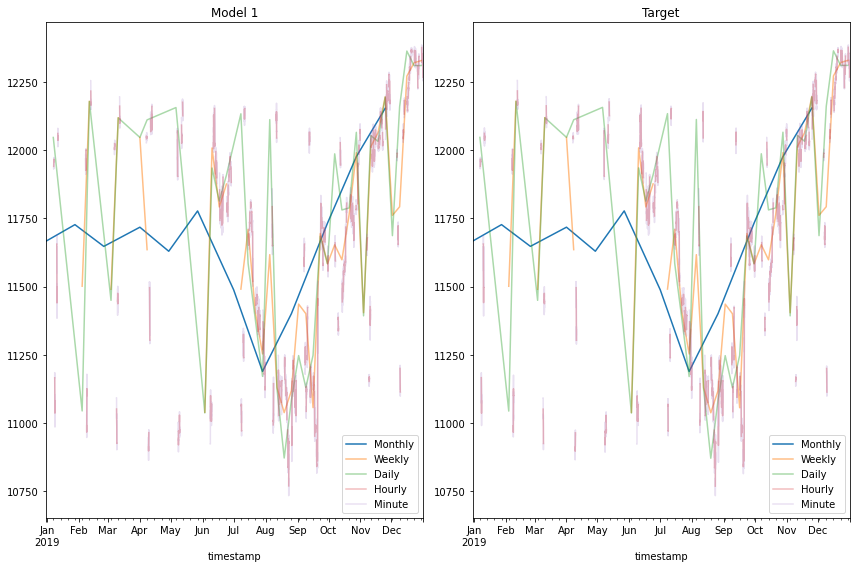

In [21]:
plt.figure(figsize=(12,8))

plt.subplot(121)
y_test.resample('M').yhat_lm1.mean().plot(label='Monthly')
y_test.resample('W').yhat_lm1.mean().plot(alpha=.5, label='Weekly')
y_test.resample('D').yhat_lm1.mean().plot(alpha=.4, label='Daily')
y_test.resample('H').yhat_lm1.mean().plot(alpha=.3, label='Hourly')
y_test.resample('T').yhat_lm1.mean().plot(alpha=.2, label='Minute')
plt.title('Model 1')
plt.legend()

plt.subplot(122)
y_test.resample('M').close.mean().plot(label='Monthly')
y_test.resample('W').close.mean().plot(alpha=.5, label='Weekly')
y_test.resample('D').close.mean().plot(alpha=.4, label='Daily')
y_test.resample('H').close.mean().plot(alpha=.3, label='Hourly')
y_test.resample('T').close.mean().plot(alpha=.2, label='Minute')
plt.title('Target')
plt.legend()

plt.tight_layout()


# Conclusions:

- An OLS Regression model using opening, high, mid-range, and low prices predicts closing price for India's National Stock Exchange Nifty 100 index for dates after 12-31-2019 to within 1.37 Indian rupees, beating the baseline by more than 432 rupees.
- The lack of categorical variables or any other variables that were not directly related to price made it impossible to add any context or draw conclusions about why the index's price is what it is and/or why the model predictions are what they are.
- Some very creative feature engineering or an aggregation of other features matched to the data might improve the predictive power of this model.
- There is also room for improving upon the modeling within the confines of the existing data by further manipulation of the hyperparameters.